The goal is to classify sequences. Elements and targets are represented locally (input vectors with only one non-zero bit). The sequence starts with an B, ends with a E (the “trigger symbol”), and otherwise consists of randomly chosen symbols from the set {a, b, c, d} except for two elements at positions t1 and t2 that are either X or Y. For the DifficultyLevel.HARD case, the sequence length is randomly chosen between 100 and 110, t1 is randomly chosen between 10 and 20, and t2 is randomly chosen between 50 and 60. There are 4 sequence classes Q, R, S, and U, which depend on the temporal order of X and Y.

The rules are:

X, X -> Q,
X, Y -> R,
Y, X -> S,
Y, Y -> U.

In [33]:
from helpers.sequential_tasks import TemporalOrderExp6aSequence as QRSU

In [34]:
# Create a data generator
example_generator = QRSU.get_predefined_generator(
    difficulty_level=QRSU.DifficultyLevel.EASY,
    batch_size=32,
)

example_batch = example_generator[1]
print(f'The return type is a {type(example_batch)} with length {len(example_batch)}.')
print(f'The first item in the tuple is the batch of sequences with shape {example_batch[0].shape}.')
print(f'The first element in the batch of sequences is:\n {example_batch[0][0, :, :]}')
print(f'The second item in the tuple is the corresponding batch of class labels with shape {example_batch[1].shape}.')
print(f'The first element in the batch of class labels is:\n {example_batch[1][0, :]}')

The return type is a <class 'tuple'> with length 2.
The first item in the tuple is the batch of sequences with shape (32, 9, 8).
The first element in the batch of sequences is:
 [[0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0]
 [0 0 0 1 0 0 0 0]
 [1 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0]
 [1 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0]
 [0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 1]]
The second item in the tuple is the corresponding batch of class labels with shape (32, 4).
The first element in the batch of class labels is:
 [1. 0. 0. 0.]


In [35]:
# Decoding the first sequence
sequence_decoded = example_generator.decode_x(example_batch[0][0, :, :])
print(f'The sequence is: {sequence_decoded}')

# Decoding the class label of the first sequence
class_label_decoded = example_generator.decode_y(example_batch[1][0])
print(f'The class label is: {class_label_decoded}')

The sequence is: BbXcXcbE
The class label is: Q


# 2. Defining the Model

In [36]:
import torch
import torch.nn as nn

# Set the random seed for reproducible results
torch.manual_seed(1)

In [37]:
class SimpleRNN(nn.Module):

    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        # Neural network layers assigned as attributes of a Module subclass
        # have their parameters registered for training automatically.
        self.rnn = torch.nn.RNN(input_size, hidden_size, nonlinearity='relu', batch_first=True)
        self.linear = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # The RNN also returns its hidden state but we don't use it.
        h = self.rnn(x)[0]
        x = self.linear(h)
        return x

class SimpleLSTM(nn.Module):

    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.lstm = torch.nn.LSTM(input_size, hidden_size, batch_first=True)
        self.linear = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h = self.lstm(x)[0]
        x = self.linear(h)
        return x

    def get_states_across_time(self, x):
        h_c = None
        h_list, c_list = list(), list()
        with torch.no_grad():
            for t in range(x.size(1)):
                h_c = self.lstm(x[:, [t], :], h_c)[1]
                h_list.append(h_c[0])
                c_list.append(h_c[1])
            h = torch.cat(h_list)
            c = torch.cat(c_list)
        return h, c

# 3. Defining the Training Loop

In [38]:
def train(model, train_data, criterion, optimizer, device):
    # Set the model to training mode. This will turn on layers that would
    # otherwise behave differently during evaluation, such as dropout.
    model.train()

    num_correct = 0 # store the number of sequence that will be correctly classified

    # loop for each batch of sequence
    for batch_idx in range(len(train_data)):

        # Request a batch of sequences and class labels, convert them into tensors
        # of the correct type, and then send them to the appropriate device.
        data, target = train_data[batch_idx]
        # Creates a Tensor from a numpy.ndarray.
        data, target = torch.from_numpy(data).float().to(device), torch.from_numpy(target).float().to(device)

        # Perform the forward pass of the model
        output = model(data) # Step 1

        # Pick only the output corresponding to last sequence element (input is pre padded)
        output = output[:, -1, :]

        # Compute the value of the loss for this batch. For loss functions like CrossEntropyLoss,
        # the second argument is actually expected to be a tensor of class indices rather than
        # one-hot encoded class labels. One approach is to take advantage of the one-hot encoding
        # of the target and call argmax along its second dimension to create a tensor of shape
        # (batch_size) containing the index of the class label that was hot for each sequence.
        target = target.argmax(dim=1)

        loss = criterion(output, target) # Step 2

        # Clear the gradient buffer of the previous batches 
        optimizer.zero_grad()  # Step 3

        loss.backward() # Step 4

        optimizer.step() # Step 5

        y_pred = output.argmax(dim=1)
        num_correct += (y_pred == target).sum().item()
        
        return num_correct, loss.item()


# 4. Defining the Testing Loop

In [39]:
def test(model, test_data, criterion, device):
    # Set the model to evaluation mode. This will turn off layers that would
    # otherwise behave differently during training, such as dropout.
    model.eval()

    # Store the number of sequences that were classified correctly
    num_correct = 0

    # A context manager is used to disable gradient calculations during inference
    # to reduce memory usage, as we typically don't need the gradients at this point.
    with torch.no_grad():
        for batch_idx in range(len(test_data)):
            data, target = test_data[batch_idx]
            data, target = torch.from_numpy(data).float().to(device), torch.from_numpy(target).float().to(device)

            output = model(data)

            output = output[:, -1, :]

            target = target.argmax(dim=1)
            loss = criterion(output, target)

            y_pred = output.argmax(dim=1)
            num_correct += (y_pred == target).sum().item()
        
    return num_correct, loss.item()


# 5. Putting it All Together

In [40]:
import matplotlib.pyplot as plt

In [45]:
def train_and_test(model, train_data, test_data, criterion, optimizer, max_epochs, verbose = True):
    # Automatically determine the device that PyTorch should use for computation
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    model.to(device)

    # Track the value of the loss function and model accuracy across epochs
    history_train = {'loss': [],'acc': [] }
    history_test = {'loss': [],'acc': [] }

    for epoch in range(max_epochs):
        num_correct, loss = train(model, train_data, criterion, optimizer, device)
        accuracy = float(num_correct)/(len(train_data)*train_data.batch_size)*100
        history_train['loss'].append(loss)
        history_test['acc'].append(accuracy)

        num_correct, loss = test(model, test_data, criterion, device)
        accuracy = float(num_correct) / (len(test_data) * test_data.batch_size) * 100
        history_test['loss'].append(loss)
        history_test['acc'].append(accuracy)

        if verbose or epoch + 1 == max_epochs:
            print(f'[Epoch {epoch + 1}/{max_epochs}]'
                  #f" loss: {history_train['loss'][-1]:.4f}, acc: {history_train['acc'][-1]:2.2f}%"
                  #f" - test_loss: {history_test['loss'][-1]:.4f}, test_acc: {history_test['acc'][-1]:2.2f}%"
            )
    
    # Generate diagnostic plots for the loss and accuracy
    fig, axes = plt.subplots(ncols=2, figsize=(9, 4.5))
    for ax, metric in zip(axes, ['loss', 'acc']):
        ax.plot(history_train[metric])
        ax.plot(history_test[metric])
        ax.set_xlabel('epoch', fontsize=12)
        ax.set_ylabel(metric, fontsize=12)
        ax.legend(['Train', 'Test'], loc='best')
    plt.show()

    return model

# LSTM: Increasing Epoch to 100

[Epoch 100/100]


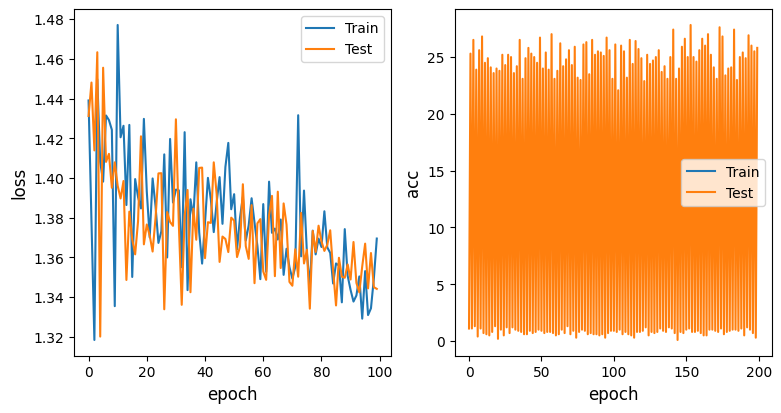

In [46]:
# Setup the training and test data generators
difficulty     = QRSU.DifficultyLevel.EASY
batch_size     = 32
train_data_gen = QRSU.get_predefined_generator(difficulty, batch_size)
test_data_gen  = QRSU.get_predefined_generator(difficulty, batch_size)

# Setup the RNN and training settings
input_size  = train_data_gen.n_symbols
hidden_size = 4
output_size = train_data_gen.n_classes
model       = SimpleLSTM(input_size, hidden_size, output_size)
criterion   = torch.nn.CrossEntropyLoss()
optimizer   = torch.optim.RMSprop(model.parameters(), lr=0.001)
max_epochs  = 100

# Train the model
model = train_and_test(model, train_data_gen, test_data_gen, criterion, optimizer, max_epochs, verbose=False)